# Titanic: Machine Learning from Disaster

From the Kaggle competition [description](https://www.kaggle.com/c/titanic/data) ...

<blockquote>In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.</blockquote>

In [1]:
import math
import pandas as pd
import numpy as np

# Do not use normal form (scietific notation) when printing numbers, exponents can make it harder to compare values
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
#%pylab inline
# pylab.rcParams['figure.figsize'] = (15, 6)

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
'numpy: {}, pandas: {}, sklearn: {}'.format(np.__version__, pd.__version__, sklearn.__version__)

'numpy: 1.14.5, pandas: 0.23.3, sklearn: 0.19.1'

## Import

In [3]:
def read_titanic_data(filename):
    return pd.read_csv("../datasets/kaggle/titanic/" + filename, index_col="PassengerId")

In [4]:
train_data = read_titanic_data("train.csv")
test_data = read_titanic_data("test.csv")

In [5]:
X_train = train_data.drop(["Survived"], axis=1)
y_train = train_data["Survived"].copy()
X_test = test_data.copy()

## Explore

In [25]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,NaN,S


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [27]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


View the distribution of categorical data

In [28]:
train_data.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Boulos, Mrs. Joseph (Sultana)",male,1601,G6,S
freq,1,577,7,4,644


In [29]:
train_data.shape

(891, 11)

View histograms of all numeric features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023132D32A58>,
      dtype=object)

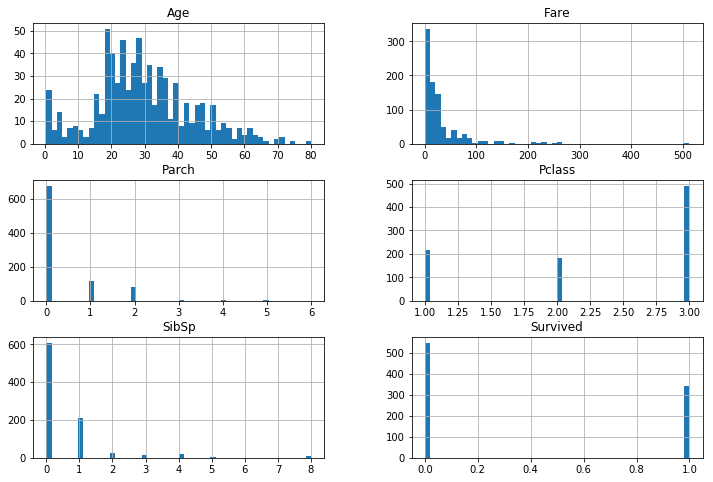

In [39]:
train_data.hist(bins=50, figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000231348E66D8>,
      dtype=object)

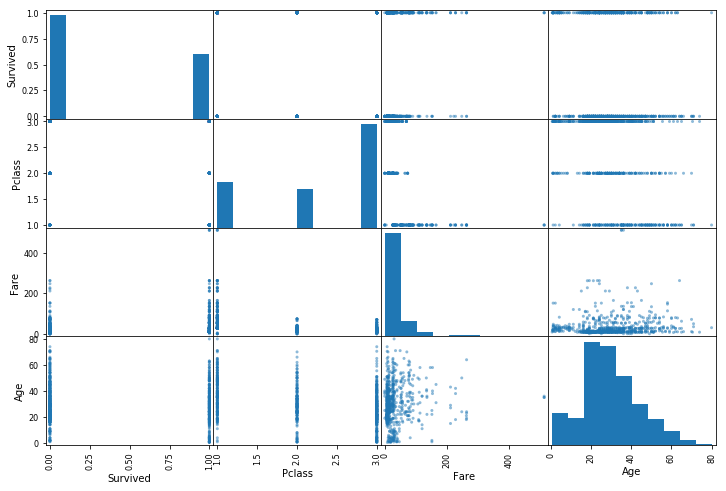

In [46]:
from pandas.plotting import scatter_matrix

scatter_features = ["Survived", "Pclass", "Fare", "Age"]
scatter_matrix(train_data[scatter_features], figsize=(12, 8))

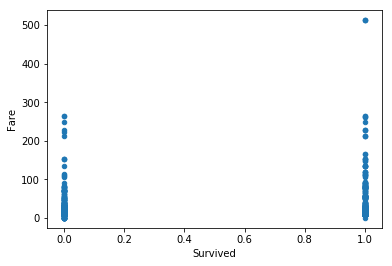

In [47]:
train_data.plot(kind="scatter", x="Survived", y="Fare")

In [32]:
class_counts = train_data["Pclass"].value_counts()
class_counts

3    491
1    216
2    184
Name: Pclass, dtype: int64

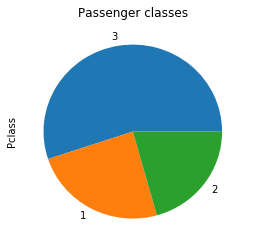

In [45]:
class_counts.plot(kind="pie", title="Passenger classes", figsize=(4, 4))

Investigate correlations

In [34]:
corr_matrix = train_data.corr()

In [38]:
corr_matrix["Survived"]

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [35]:
corr_survived = corr_matrix["Survived"].drop("Survived")

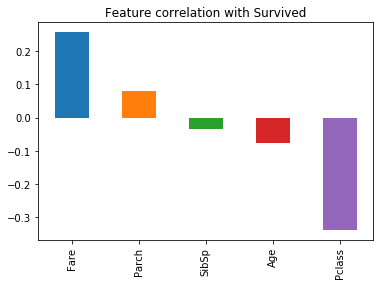

In [36]:
corr_survived.sort_values(ascending=False).plot(kind='bar', title='Feature correlation with Survived')

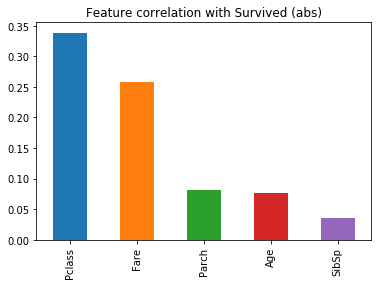

In [37]:
corr_survived.abs().sort_values(ascending=False).plot(kind='bar', title='Feature correlation with Survived (abs)')

View the correlation between passenger class and survival

In [51]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


## Feature engineering

Extract a list of `Title`s, used to map down to smaller set of category values

In [6]:
pd.concat(
    [test_data["Name"].str.extract(' ([A-Za-z]+)\.', expand=False),
    train_data["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)]
).value_counts()


Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Jonkheer      1
Sir           1
Don           1
Dona          1
Countess      1
Capt          1
Lady          1
Mme           1
Name: Name, dtype: int64

#### Process _Embarked_

Find the most common embarcation point

In [7]:
train_data["Embarked"].value_counts().head(1)

S    644
Name: Embarked, dtype: int64

## Using a pipeline

Build a pipeline to apply the following transformations

1. Extract Title from _Name_
2. Calculate FamilySize from _SibSp_ and _Parch_
3. Replace _Embarked_ codes with city names
4. One-hot encode _Embarked_, _Sex_ and _Title_
5. Drop _Name_, _Age_, _Cabin_ and _Ticket_ features
6. Fill _Fare_ with mean (there's a NaN Fare in the test set)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [13]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """Transformer that drops the given columns
    """
    
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.drop(self.columns, axis=1)

In [11]:
class ExtractFamilySizeTransformer(BaseEstimator, TransformerMixin):
    """Transformer that extracts a FamilySize column from SibSp and Parch
    """
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.assign(FamilySize = lambda _: _.SibSp + _.Parch + 1)

In [10]:
class ExtractTitleTransformer(BaseEstimator, TransformerMixin):
    """Transformer that extracts a Title column from Name
    """
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.assign(Title = lambda _: _.Name.str.extract(' ([A-Za-z]+)\.', expand=False))

In [9]:
class FillnaTransformer(BaseEstimator, TransformerMixin):
    """Transformer that fills in NA values
    """
    
    def __init__(self, value):
        self.value=value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [14]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    """Transformer that one-hot encodes the given columns
    """
    
    def __init__(self, columns=None, drop_first=False):
        self.columns = columns
        self.drop_first=drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, columns=self.columns, drop_first=self.drop_first)

In [16]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that imputes missing values
    """    
    
    def __init__(self, strategy="mean"):
        self.strategy=strategy
    def fit(self, X, y=None):
        self.imputer = Imputer(strategy=self.strategy).fit(X)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.imputer.transform(X), index=X.index, columns=X.columns)

In [15]:
class ReplaceValueTransformer(BaseEstimator, TransformerMixin):
    """Transformer that replaces values
    """
    
    def __init__(self, to_replace, value):
        self.to_replace = to_replace
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X[self.to_replace].replace(self.value, inplace=True)
        return X

In [12]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    """Transformer that selects a set of columns
    """
    
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [17]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """Transformer to select the most important attributes
    
    For performance reasons feature importances should be calculated outside the estimator
    """
        
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[:, self.feature_indices_]

In [18]:
titles = {
    "Mr": "Mr",
    "Miss" : "Miss",
    "Mrs" : "Mrs",
    "Master" : "Master",
    "Dr": "Mr",
    "Rev": "Mr",
    "Mlle": "Miss",
    "Major": "Mr",
    "Col": "Mr",
    "Ms": "Mrs",
    "Sir" : "Mr",    
    "Jonkheer": "Mr",
    "Mme": "Mrs",
    "Don": "Mr",
    "Dona": "Mrs",
    "Countess":"Mrs",
    "Lady" : "Mrs",
    "Capt": "Mr"    
}

cities = {
    "C": "Cherbourg", 
    "Q": "Queenstown", 
    "S": "Southampton"
}

sex = {
    "male": 0,
    "female": 1
}

In [19]:
transformation_pipeline = Pipeline([
                ('extract_title', ExtractTitleTransformer()),
                ('replace_title', ReplaceValueTransformer("Title", titles)),
                ('extract_family_size', ExtractFamilySizeTransformer()),
                ('fill_embarked', FillnaTransformer({"Embarked": "S"})), # fill with most frequent city
                ('replace_embarked', ReplaceValueTransformer("Embarked", cities)),
                ('get_dummies', GetDummiesTransformer(["Embarked", "Sex", "Title"])),
                ('drop_columns', DropColumnsTransformer(["Name", "Cabin", "Ticket", "SibSp", "Parch"])),
                ('impute_values', ImputerTransformer())
            ])

In [20]:
X_train_transformed = transformation_pipeline.fit_transform(X_train.copy())

In [21]:
X_train_transformed.head()

,Pclass,Age,Fare,FamilySize,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,
1,3.000000,22.000000,7.250000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2,1.000000,38.000000,71.283300,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,3.000000,26.000000,7.925000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,1.000000,35.000000,53.100000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,3.000000,35.000000,8.050000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000


## Train a model

In [22]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [23]:
def view_best_of_grid(grid: GridSearchCV):
    print("best score:", grid.best_score_)
    print("best params:", grid.best_params_)
    print("best estimator:", grid.best_estimator_)

In [24]:
def show_null_samples(frame):
    print(frame[frame.isnull().any(axis=1)])

### Train LinearSVC

In [27]:
from sklearn.svm import LinearSVC

In [28]:
clf_svc = LinearSVC(penalty="l2", dual=False, tol=1e-4)
clf_svc.fit(X_train, y_train)

ValueError: could not convert string to float: 'Q'

In [256]:
y_hat_svc = clf_svc.predict(X_test)

### Train DecisionTreeClassifier

In [363]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)                           

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [364]:
y_hat_tree = clf_tree.predict(X_test)

In [365]:
clf_tree.score(X_train, y_train)

0.9270482603815937

In [371]:
clf_scores = cross_val_score(clf_tree, X_train, y_train, cv=20)

In [372]:
clf_scores.mean()

0.8273276240667545

### Train a random forrest

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf_forrest = RandomForestClassifier(random_state=0, n_jobs=4)

In [26]:
forrest_param_grid = [{ 
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [30, 100, 300],
    "max_depth": [2, 4, 8],
    "max_features": [0.8, 1.0],
    "max_leaf_nodes": [4, 8, 16]
}]

clf_forrest_grid = GridSearchCV(clf_forrest, forrest_param_grid)

clf_forrest_grid.fit(X_train, y_train)

ValueError: could not convert string to float: 'Q'

In [39]:
view_best_of_grid(clf_forrest_grid)

best score: 0.835016835016835
best params: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.8, 'max_leaf_nodes': 8, 'n_estimators': 300}
best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=0.8, max_leaf_nodes=8,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [40]:
y_hat_forrest = clf_forrest_grid.predict(X_test)

### Train a gradient boosted classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
gb_params = [{ 
    "prepare_data__get_dummies__drop_first": [True, False],
    "gb_clf__learning_rate": [0.4, 0.5, 0.6, 0.8, 1.0],
    "gb_clf__n_estimators": [10, 30, 100, 150],
    "gb_clf__max_depth": [2, 3, 4],
    "gb_clf__max_features": [0.5, 0.6, 0.8, 1.0]
}]

In [31]:
gb_clf_pipeline = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('gb_clf', GradientBoostingClassifier(random_state=42))
])

In [32]:
gb_clf = GridSearchCV(gb_clf_pipeline, gb_params, cv=3, verbose=1)

These are all the hyperparameters that can potentially be set

In [33]:
list(gb_clf_pipeline.get_params().keys())

['memory',
 'steps',
 'prepare_data',
 'gb_clf',
 'prepare_data__memory',
 'prepare_data__steps',
 'prepare_data__extract_title',
 'prepare_data__replace_title',
 'prepare_data__extract_family_size',
 'prepare_data__fill_embarked',
 'prepare_data__replace_embarked',
 'prepare_data__get_dummies',
 'prepare_data__drop_columns',
 'prepare_data__impute_values',
 'prepare_data__replace_title__to_replace',
 'prepare_data__replace_title__value',
 'prepare_data__fill_embarked__value',
 'prepare_data__replace_embarked__to_replace',
 'prepare_data__replace_embarked__value',
 'prepare_data__get_dummies__columns',
 'prepare_data__get_dummies__drop_first',
 'prepare_data__drop_columns__columns',
 'prepare_data__impute_values__strategy',
 'gb_clf__criterion',
 'gb_clf__init',
 'gb_clf__learning_rate',
 'gb_clf__loss',
 'gb_clf__max_depth',
 'gb_clf__max_features',
 'gb_clf__max_leaf_nodes',
 'gb_clf__min_impurity_decrease',
 'gb_clf__min_impurity_split',
 'gb_clf__min_samples_leaf',
 'gb_clf__min_sa

In [34]:
gb_clf.fit(X_train.copy(), y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'prepare_data__get_dummies__drop_first': [True, False], 'gb_clf__learning_rate': [0.4, 0.5, 0.6, 0.8, 1.0], 'gb_clf__n_estimators': [10, 30, 100, 150], 'gb_clf__max_depth': [2, 3, 4], 'gb_clf__max_features': [0.5, 0.6, 0.8, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
view_best_of_grid(gb_clf)

best score: 0.8383838383838383
best params: {'gb_clf__learning_rate': 0.8, 'gb_clf__max_depth': 2, 'gb_clf__max_features': 0.5, 'gb_clf__n_estimators': 30, 'prepare_data__get_dummies__drop_first': True}
best estimator: Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])


In [36]:
gb_clf_score = gb_clf.score(X_train, y_train)
"best gradient boosting classifier score: {}".format(gb_clf_score)

'best gradient boosting classifier score: 0.8855218855218855'

In [37]:
y_hat_gb = gb_clf.predict(X_test.copy()) 

## Evaluate

Plot the feature coefficients

In [267]:
coefficients = pd.Series(clf_svc.coef_[0], X_train.columns).sort_values()

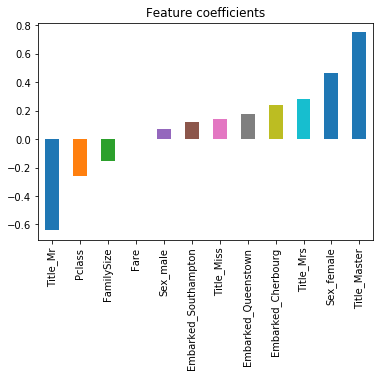

In [258]:
coefficients.plot(kind='bar', title='Feature coefficients')

View the R^2 on the training dataset

In [259]:
r_square_train = clf_svc.score(X_train, y_train)
r_square_train

0.8327721661054994

## Submit

Create submission

In [360]:
submission = pd.DataFrame({
  "PassengerId": X_test.index,
  "Survived": y_hat_gb
})

In [361]:
submission.to_csv("../datasets/kaggle/titanic/submission.csv", index=False)

Submit using the Kaggle CLI

In [362]:
!kaggle competitions submit -c titanic -f ../datasets/kaggle/titanic/submission.csv -m "Use gradient tree boosting"`

Successfully submitted to Titanic: Machine Learning from Disaster


Jump to the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) to see the score and ranking

# Summary

| Model              | Notes                            | Model score | Kaggle score   | Leaderboard |
| ------------------ | -------------------------------- | ----------- | -------------- | ----------- |
| `LinearSVC`        | Bare bones feature engineering   |     0.79910 |        0.77033 |       6,981 |
| `LinearSVC`        | Added Title and 1-hot encoded it |     0.82940 |        0.78947 |       3,587 |
| `LinearSVC`        | Added FamilySize feature         |     0.83277 |        0.78947 |       3,507 |
| `DecisionTree`     | Using a decision tree model      |             |        0.79425 |       2,493 |
| `RandomForrest`    | With grid search                 |     0.83501 |        0.79904 |       1,764 |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |

